# Multilabel classifier

Model that classifies if an image is flawed (BLR, FRM or clear).

In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import json
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import random
import copy
import io
import cv2
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

%matplotlib inline


# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
cuda:0


**Load images data**

In [2]:
with open(f'../data/vw_mc_dataset.json', encoding='UTF-8') as m_json_file:
    data = json.load(m_json_file)
    mc_train_data = np.array(data["train"], dtype=object)
    mc_val_data = np.array(data["val"], dtype=object)
    mc_test_data = np.array(data["test"], dtype=object)

## Dataset

In [3]:
class ImageDataset(Dataset):

    def __init__(self, root_dir, imgs_list, transform=None):

        self.root_dir = root_dir
        self.imgs_list = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

         # VizWiz dataset case
        img_name = os.path.join(self.root_dir, self.imgs_list[idx][0])
    
        labels = self.imgs_list[idx][1::] # [x, y, z]  
        label = int(np.where(labels == 1)[0][0]) # idx
        
        image = Image.open(img_name)

        if self.transform:
            image = self.transform(image)
        
        return image, label
                

## Training

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_path):
    """
    Train the model
    """
    
    since = time.time()

    acc_history = {"train": [], "val": []}
    losses = {"train": [], "val": []}

    # we will keep a copy of the best weights so far according to validation accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loss_fn = tloss_fn
            else:
                model.eval()   # Set model to evaluate mode
                loss_fn = vloss_fn

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = loss_fn(outputs.float(), labels)
                    losses[phase].append(loss.cpu().detach().numpy())
                    preds = torch.argmax(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            acc_history[phase].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    
    torch.save(model.state_dict(), save_path)
    
    return model, acc_history, losses

In [5]:
def initialize_model(num_classes, model_name):
    """
    Initialize blur model for binary classifaction
    """
    
    if str(model_name) == "vgg16" or str(model_name) == "convnext":
        
        if str(model_name) == "vgg16":
            model = models.vgg16(weights='IMAGENET1K_V1')
        else:
            model = models.convnext_tiny(weights='IMAGENET1K_V1')
                                         
        num_ftrs = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(num_ftrs, num_classes)
                                         
    elif str(model_name) == "resnet":
        model = models.resnet18(weights='IMAGENET1K_V1')
        model.fc = nn.Linear(512, num_classes)
        
    input_size = 224
        
    return model, input_size


# Number of classes in the dataset
num_classes = 3

# Initialize the model
model_name = "convnext"
model, input_size = initialize_model(num_classes, model_name)
print(model)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [6]:
def calculate_ce_weights(data):
    
    class_samples = []
    
    for nc in [1,2,3]:
        n_samples_c = data[np.where(data[:, nc] == 1)].shape[0]
        class_samples.append(n_samples_c)

    total_train_samples = sum(class_samples)
    class_weights = [total_train_samples / (len(class_samples) * samples) for samples in class_samples]
    class_weights = torch.FloatTensor(class_weights)
    
    return class_weights

In [7]:
# Send the model to GPU
model = model.to(device)

# Weighted Cross entropy loss 
class_weights = calculate_ce_weights(np.array(mc_train_data, dtype=object))
class_weights = torch.FloatTensor(class_weights).cuda()
tloss_fn = nn.CrossEntropyLoss(weight=class_weights)
vloss_fn = nn.CrossEntropyLoss()

**Model params**

In [8]:
hp = {"lr" : 2.5672e-5}

In [9]:
batch_size = 128
num_epochs = 5
lr = hp["lr"]
optimizer = optim.AdamW(model.parameters(), lr=lr)

**Data**

In [10]:
def get_transform_normalize_values(simple_transforms, loader):
    
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) 
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)

    mean /= len(loader.dataset)
    std /= len(loader.dataset)

    return mean, std

In [22]:
train_dir = '/media/arnau/SSD/VizWiz/multiclass/train/'
val_dir = '/media/arnau/SSD/VizWiz/multiclass/val/'
test_dir = '/media/arnau/SSD/VizWiz/multiclass/test/'

In [12]:
norm_path = f'../outputs/norms.pkl'
input_size = (224,224)

if not os.path.exists(norm_path):

    trnfsm = transforms.Compose([
            transforms.Resize(input_size),
            transforms.ToTensor()])

    train_dataset = ImageDataset(train_dir, mc_train_data, trnfsm)
    train_loader = DataLoader(train_dataset, batch_size=10, num_workers=0,
                        shuffle=False)

    train_mean, train_std = get_transform_normalize_values(trnfsm, train_loader)

    train_normalize = transforms.Normalize(mean=train_mean, std=train_std)

    with open(norm_path, 'wb') as f:
        pickle.dump(train_normalize, f)

else:
    with open(norm_path, 'rb') as f:
        train_normalize = pickle.load(f)
    
# Set transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(input_size),
        transforms.RandomCrop((int(input_size[0] * 0.75), 
                               int(input_size[1] * 0.75))),
        transforms.GaussianBlur(kernel_size=5, 
                                sigma=(0.1, 2.0)),
        transforms.ToTensor(),
        train_normalize

    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        train_normalize
    ])
}

In [13]:
train_dataset = ImageDataset(train_dir, mc_train_data, data_transforms["train"])
val_dataset = ImageDataset(val_dir, mc_val_data, data_transforms["val"])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

dataloaders_dict = {"train": train_loader, "val": val_loader}

**Model trainning**

Epoch 0/4
----------
train Loss: 1.0076 Acc: 0.4843
val Loss: 0.9040 Acc: 0.5805

Epoch 1/4
----------
train Loss: 0.8440 Acc: 0.6195
val Loss: 0.7901 Acc: 0.6494

Epoch 2/4
----------
train Loss: 0.7616 Acc: 0.6631
val Loss: 0.7248 Acc: 0.6756

Epoch 3/4
----------
train Loss: 0.7286 Acc: 0.6784
val Loss: 0.7268 Acc: 0.6743

Epoch 4/4
----------
train Loss: 0.6711 Acc: 0.7085
val Loss: 0.6937 Acc: 0.6967

Training complete in 17m 44s
Best val Acc: 0.696679


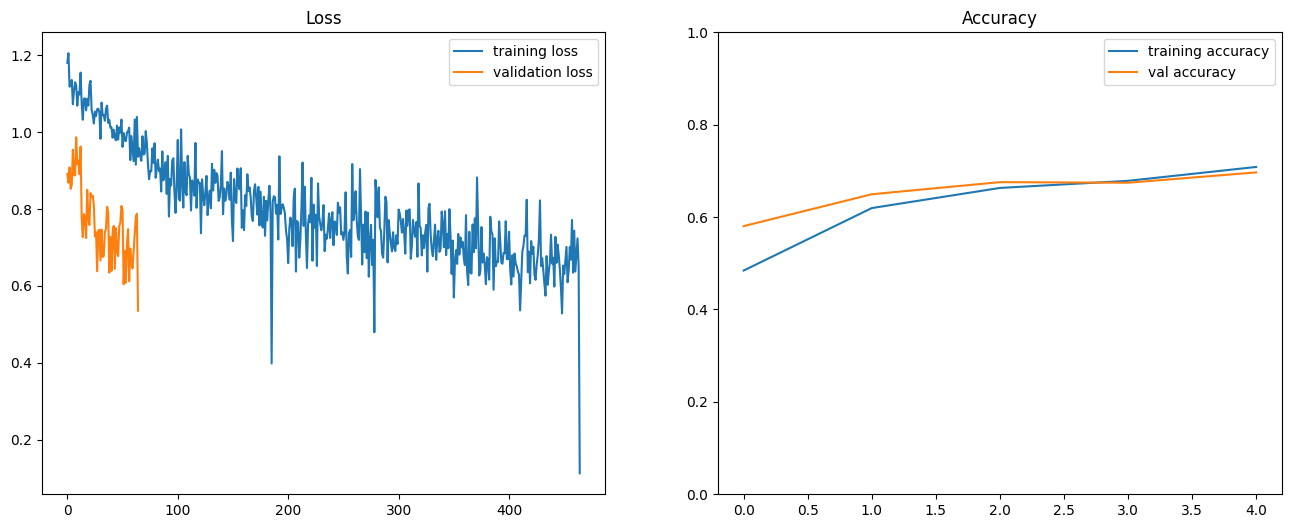

In [15]:
save_path = f'../outputs/best_MC_{model_name}.pth'

if not os.path.exists(save_path):
    # Train and evaluate
    model, hist, losses = train_model(model, dataloaders_dict, tloss_fn, optimizer, 
                                      num_epochs=num_epochs, save_path=save_path)
    
    # plot the losses and accuracies
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title("Loss")
    ax1.plot(losses["train"], label="training loss")
    ax1.plot(losses["val"], label="validation loss")
    ax1.legend()

    ax2.set_title("Accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["train"]],label="training accuracy")
    ax2.plot([x.cpu().numpy() for x in hist["val"]],label="val accuracy")
    ax2.set_ylim([0, 1])
    ax2.legend()

    plt.show()

## Results

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)

print(f"Number of trainable parameters in the model: {num_params}")

Number of trainable parameters in the model: 27822435


In [39]:
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

def plot_aoc_roc_curve(y_true, y_pred):
    # Calculate AUC-ROC score and ROC curve using sklearn
    auc_roc = roc_auc_score(y_true, y_pred, multi_class='ovr')
    fpr, tpr, thresholds = roc_curve(y_true, y_pred, multi_class='ovr')

    # Plot ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_roc))
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()
    
    
def plot_confusion_matrix(cm, classes):
    """
    This function plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

    
def evaluate(model, loss_fn, test_loader, device):
    """
    Evaluate the model on the test set
    """
    
    model.eval()

    test_loss = 0.0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs.float(), targets)
        test_loss += loss.item() * inputs.size(0)
        #predicted = torch.round(torch.sigmoid(outputs))
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += torch.sum(predicted == targets.data)
        y_true += targets.cpu().numpy().tolist()
        y_pred += predicted.cpu().detach().numpy().tolist()

    test_loss /= len(test_loader.dataset)
    test_acc = correct / total
    test_f1 = f1_score(y_true, y_pred, average='weighted')
    test_precision = precision_score(y_true, y_pred, average='weighted')
    test_recall = recall_score(y_true, y_pred, average='weighted')

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc * 100:.2f}%")
    print(f"Test F1 Score: {test_f1 * 100:.2f}%")
    print(f"Test Precision: {test_precision * 100:.2f}%")
    print(f"Test Recall: {test_recall * 100:.2f}%")

    cm = confusion_matrix(y_true, y_pred)
    
    return y_true, y_pred, cm

**Results on test set**

**NOTE**: Thanks to previous preprocessing, test sat does not contain images from val set.

Test Loss: 0.7198
Test Accuracy: 68.83%
Test F1 Score: 68.50%
Test Precision: 69.74%
Test Recall: 68.83%


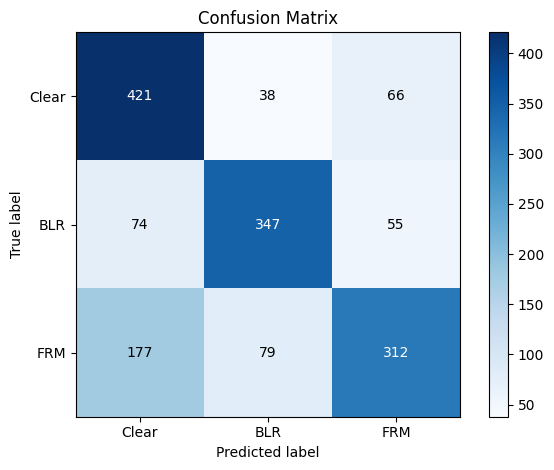

In [41]:
test_dataset = ImageDataset(test_dir, mc_test_data, data_transforms["val"])
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

model.load_state_dict(torch.load(save_path))

class_labels = ['Clear', 'BLR', 'FRM']

yt, yp, cm = evaluate(model, tloss_fn, test_loader, device)

#plot_aoc_roc_curve(yt, yp)
plot_confusion_matrix(cm, classes=class_labels)

In [48]:
def inference(i):
    """
    Model outputs 1 if the image is blurred otherwise 0
    """
    
    img = Image.open(i)

    transform = transforms.Compose([
        transforms.Resize((224, 224)), 
        transforms.ToTensor(),        
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        output = model(img_tensor)

    _, predicted = torch.max(output.data, 1)
    #predicted = torch.round(torch.sigmoid(output))
    pred = predicted.cpu().detach().numpy()[0]
    
    return pred

**Inference visualization**

Visualization of how the model performs

Model: Clear
True: Clear


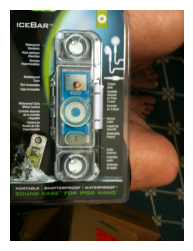

Model: Clear
True: Clear


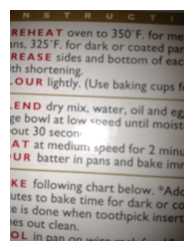

Model: FRM
True: FRM


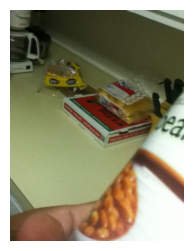

Model: Clear
True: FRM


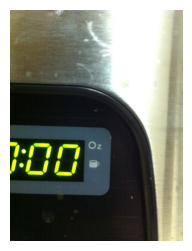

Model: Clear
True: Clear


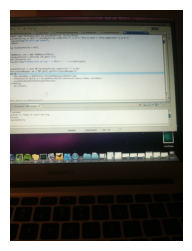

In [54]:
ten_random_imgs = random.choices(mc_test_data, k=5)
labels_names = {0 : "Clear", 1 : "BLR", 2 : "FRM"}

for i, data in enumerate(ten_random_imgs):
    plt.figure(figsize=(3, 3))
    img_name = data[0]
    label = np.where(data[1::] == 1)[0][0]
    img = test_dir + img_name
    model_pred = inference(img)
    model_pred = labels_names[model_pred]
    print(f"Model: {model_pred}")
    true_label = labels_names[label]
    print(f"True: {true_label}")
    img = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    img = (img.astype(np.float32) / np.max(img) * 255).astype(np.uint8)
    plt.imshow(img)
    plt.axis('off')
    plt.show()